<a href="https://colab.research.google.com/github/dafaagil12321/TAKODE/blob/main/KODETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import pi
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [ ]:
kcay =3*(10**8)
lamb= 800*(10**(-9))
lamb
omglamb= (2*np.pi*kcay/lamb)/(4.134*(10**16))
omglamb

0.0569955125832691

In [ ]:
class Params:
    """Container for holding all simulation parameters."""
    def __init__(self,
                 xmax: float,
                 #res: int,
                 #dt: float,
                 #timesteps: int,
                 im_time: bool) -> None:

        self.xmax = xmax

        # self.period = 32.97*41
        # self.omega = 0.0225
        # self.period = 2 * np.pi/ self.omega
        self.omega = omglamb
        # self.omega2 = self.omega * 0.4
        self.period = 2 * np.pi/ self.omega
        # self.period2 = 2 * np.pi/ self.omega2
        # self.tau =0.05*self.period
        self.tmax = 8*self.period
        self.dt = 0.05
        self.timesteps = int(self.tmax / self.dt)
        self.im_time = im_time


        self.dx = 0.01 #2 * xmax / res
        self.res = int(2*self.xmax/self.dx)
        self.x = np.arange(-xmax, xmax, self.dx)
        self.dk = pi / xmax
        self.k = np.concatenate((np.arange(0, self.res / 2),
                                 np.arange(-self.res / 2, 0))) * self.dk

In [ ]:
# Matriks tridiagonal
def tridag(a,b,c,u,n,ng):
    temp=b[0]
    u[0]=u[0]/temp
    for j in range(1,n):
        temp1 = b[j]
        b[j]  = c/temp
        temp  = temp1-a*b[j]
        u[j]  = (u[j]-a*u[j-1])/temp
    for j in range (n-2,-1,-1):
        u[j]  = u[j]-b[j+1]*u[j+1]
    return u

# rumus filter untuk potensial 1 dimensi
def filter1D(dx,vpot,psi,energy,n,k):
    dx2 = dx*dx
    a = -0.5/dx2
    c = a
    odx2 = 1/dx2
    b=np.zeros(n)
    #k adalah jumlah perulangan filter
    for k in range(0,5):
        for i in range(0,n):
            b[i] = (odx2+vpot[i]-energy)
        global tridag
        psi = tridag(a,b,c,psi,n,n)
    fnorm = sum(psi*psi)*dx
    psi = psi / (fnorm**0.5)
    return psi

# rumusan hamiltonian
def hamiltonian(dx,vpot,psi,ng):
    dx2 = dx*dx
    a =-0.5/dx2
    c = a
    odx = 1/dx2
    u = np.zeros(ng)
    u[0] =((odx+vpot[0])*psi[0] + c*psi[1])
    for i in range (1,ng-1):
        u[i] = (a*psi[i-1]+(odx+vpot[i])*psi[i]+c*psi[i+1])
    u[-1]=((a*psi[-2])+(odx+vpot[-1])*psi[-1])
    psiu = psi*u
    energy_new = sum(psiu)*dx
    return energy_new

# Rumusan eigenstate
def eigenState(x, ngrid, vpot, initE, dx):
    if initE <= 0 :
        initE = initE + 1e-12
    x_tart = x[0]
    x_end = x[ngrid - 1]
    psi = np.zeros(ngrid)
    if x_tart < 0:
        for i in range(0,ngrid):
            psi[i] = (np.sin(x[i]) + np.cos(x[i]))
    else:
        for i in range(0,ngrid):
           psi[i] = 1 + x[i] / x_end
    #psi=np.linspace(1,1,ngrid) + x/x[-1]
    energy = initE
    error = 1e3
    loop = 1
    while error>1e-10:
        nloop = 10
        if loop ==1:
            nloop = 10 #nloop
        global filter1D
        global hamiltonian
        psi = filter1D(dx,vpot,psi,energy,ngrid,nloop)
        energy_new =  hamiltonian(dx,vpot,psi,ngrid)
        error = abs(energy_new-energy)#/energy
        energy = energy_new
        loop = loop+1
    output = [energy_new,psi]
    return output

In [ ]:
par = Params(512,False)

In [ ]:
xmin = -par.xmax
xmax = par.xmax
dx = par.dx
x = par.x
ngrid = par.res
vpot1 = -1/((1.41 + par.x**2)**0.5)
gradPot1 = par.x/(1.41 + par.x**2)**1.5

In [ ]:
initE = -0.5799
E1, psi1 = eigenState(x, ngrid,vpot1, initE, dx)

In [ ]:
E1

-0.5799127660476454

/var/tmp/pbs.7032.nebula/ipykernel_111447/4231770195.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


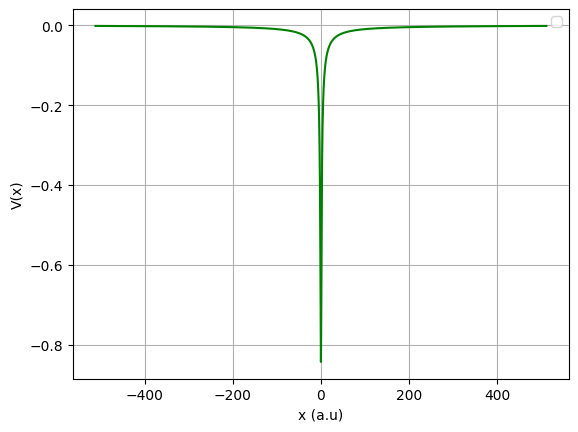

In [ ]:
plt.plot(x,vpot1,  color = 'green')
plt.ylabel("V(x)")
plt.xlabel("x (a.u)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def cosine_mask():
    edge_width = 3100
    mask = np.ones(len(par.x))
    edge_indices = np.arange(edge_width)
    edge_values = 0.5 - 0.5 * np.cos(np.pi * edge_indices / edge_width)
    mask[:edge_width] = edge_values
    mask[-edge_width:] = edge_values[::-1]
    return mask

In [ ]:
def wavefunction(opr_psi, opr_V,):

    opr_K = np.exp(-0.5*(par.k ** 2) * par.dt * 1j)
    opr_R = np.exp(-0.5 * opr_V * par.dt * 1j)

    # Half-step in real space
    opr_psi *= opr_R

    # FFT to momentum space
    opr_psi = np.fft.fft(opr_psi)

    # Full step in momentum space
    opr_psi *= opr_K
    # iFFT back
    opr_psi = np.fft.ifft(opr_psi)

    # Final half-step in real space
    opr_psi *= opr_R

    opr_psi *= cosine_mask()

    return opr_psi

In [ ]:
int1=2*10**14
int2=2*10**13
# beta = int2/int1
beta =0
phi = 0
r1 = 1
s1 = 0
perm=(8.85419)*(10**(-12))
# perm=(8.854)*(10**(-12))
kcah =3*(10**8)
it =2*10**18
its=(2*it)/(np.abs(perm)*(kcah**1))
FA = (np.sqrt(its))/(5.14221*10**11)
FA2 =(np.sqrt(its*beta))/(5.14221*10**11)
Epeak = FA/(sqrt(1+beta**2))
print(FA)
print(Epeak)
itau = (2*10**14)/(3.5094*10**16)
itau
print(beta)

0.07546492436850664
0.07546492436850664
0


In [ ]:
def main(vpot, gradPot, psi):
    ngrid = len(psi)  # Jumlah grid, mungkin perlu disesuaikan
    psin = np.zeros((par.timesteps, ngrid), dtype=complex)
    acc = np.zeros((par.timesteps))
    acc2 = np.zeros((par.timesteps))
    pn0 = np.zeros((par.timesteps))
    norm = np.zeros((par.timesteps))
    hx = np.zeros((par.timesteps))
    EM = np.zeros((par.timesteps))
    vtot = np.zeros((par.timesteps, ngrid))
    psin[0] = psi

    time = np.zeros(par.timesteps)
    t = 0

    for i in range(par.timesteps-1):
        if 0 <= t < par.period:
            Em = Epeak*((np.sin(np.pi*t/(2*par.period)))**2)*(np.cos(r1*par.omega*t)+beta*np.cos(s1*par.omega*t+phi))
        elif par.period <= t <= 7*par.period:
            Em = (Epeak*(np.cos(r1*par.omega*t)+beta*np.cos(s1*par.omega*t+phi)))
        elif 7*par.period < t <= 8*par.period:
            Em = (Epeak*(((np.sin(((np.pi*t)-(0))/(2*par.period)))**2))*(np.cos(r1*par.omega*t)+beta*np.cos(s1*par.omega*t+phi)))
        else:
            Em = 0
        V = vpot - Em*par.x

        acc[i] = sum(np.real(np.conj(psin[i])*gradPot*psin[i]))*par.dx
        pn0[i] = np.abs(np.sum(psin[i] * psi) * par.dx)**2
        norm[i] = np.abs(np.sum(psin[i] * psin[i]) * par.dx)**2
        hx[i] = sum(np.real(np.conj(psin[i])*par.x*psin[i]))*par.dx
        EM[i] = Em
        psi_new = wavefunction(psin[i], V)
        time[i] = t
        vtot[i] = V
        gradV = np.gradient(V, dx)
        acc2[i] = sum(np.real(np.conj(psin[i])*gradV*psin[i]))*par.dx
        psin[i + 1] = psi_new
        t = t + par.dt


    return time, psin, vtot, acc, pn0, norm, hx, EM, acc2

In [ ]:
# time, psi1n, vtot1, acc1, pn01, norm, traj1, Em, acc21 = main(vpot1,gradPot1,psi1)

In [ ]:
# if beta == 0 or beta == 1:
#   nama_file = f"hhg2 s {s1}.dat"
# else:
#   nama_file = f"hhg2 beta {beta} s{s1}.dat"

# with open(nama_file, 'a') as f:
#  for i in range(par.timesteps):
#    f.write(f"{time[i]} {acc1[i]} {pn01[i]} {traj1[i]} {Em[i]} {norm[i]} {acc21[i]} {psi1n[i]} \n")

In [ ]:
# Mengatur nama file yang ingin dibaca
if beta == 0 or beta == 1:
    nama_file = f"hhg2 s {s1}.dat"
else:
    nama_file = f"hhg2 beta {beta} s{s1}.dat"

# Menginisialisasi list untuk menyimpan data
data = []

# Membaca data dari file .dat
try:
    with open(nama_file, 'r') as f:
        lines = f.readlines()[:-4]  # Membaca semua kecuali baris terakhir

        for line in lines:
            # Memecah setiap baris berdasarkan spasi
            values = line.split()

            # Mengecek apakah jumlah elemen cukup (minimal 7 kolom, tanpa psi1n)
            if len(values) >= 7:
                # Mengonversi nilai ke dalam tipe float untuk kolom yang diinginkan
                time = float(values[0])
                acc1 = float(values[1])
                pn01 = float(values[2])
                traj1 = float(values[3])
                Em = float(values[4])
                norm = float(values[5])
                acc21 = float(values[6])

                # Menambahkan tuple tanpa psi1n
                data.append((time, acc1, pn01, traj1, Em, norm, acc21))
            else:
                continue

    # Mengonversi list data menjadi array numpy untuk kemudahan pemrosesan
    data_array = np.array(data)

    # Menyalin data kembali ke dalam variabel terpisah
    time = data_array[:, 0]  # Kolom waktu
    acc1 = data_array[:, 1]  # Kolom acc
    pn01 = data_array[:, 2]  # Kolom probabilitas
    traj1 = data_array[:, 3] # Kolom trajektori
    Em = data_array[:, 4]    # Kolom Em
    norm = data_array[:, 5]  # Kolom norm
    acc21 = data_array[:, 6] # Kolom acc21

    # Cetak beberapa data untuk memverifikasi hasilnya
    print("Data waktu:", time)
    print("Data acc1:", acc1)

except FileNotFoundError:
    print(f"File {nama_file} tidak ditemukan.")


Data waktu: [0.0000e+00 5.0000e-02 1.0000e-01 ... 8.8170e+02 8.8175e+02 8.8180e+02]
Data acc1: [-2.83016945e-15 -2.81901575e-15  7.17623430e-12 ... -2.81722124e-03
 -2.93735805e-03 -3.05425221e-03]


In [ ]:
accnormed = acc21/np.sum(norm) #untuk spektrum
t1 = time/par.period

In [ ]:
# if beta == 0 or beta == 1:
#   nama_file = f"akseldanE{s1}.dat"
# else:
#   nama_file = f"amedanlistrikdanakselerasi{beta}s{s1}.dat"

# with open(nama_file, 'a') as f:
#  for i in range(par.timesteps-1):
#    f.write(f"{time[i]} {acc1[i]} \n")

# **MEDAN LASER**

In [ ]:
plt.plot(t1[:-1],Em[:-1], 'b')
#plt.plot(t1[:-1],traj2[:-1],'-k')
#plt.plot(t1[:-1],np.gradient(traj2[:-1])*100,'-k')
plt.ylabel('Medan Listrik (a.u)')
plt.xlabel('t (a.u)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(t1[:-1],acc21[:-1],'-g')
plt.xlabel('t (a.u)')
plt.ylabel('acc (a.u)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
par.timesteps

17638

In [ ]:

rata_rata = np.mean([n for n in norm if n != 0])
norm_koreksi = [n if n != 0 else rata_rata for n in norm]
accnew = [a / n for a, n in zip(acc1, norm_koreksi)]


In [ ]:

def calculate_hhg_spectrum(t, acceleration_data):
    fft_result = np.fft.fft(acceleration_data)
    frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
    return frequencies, np.abs(fft_result)
# Hitung spektrum HHG
frekuensi, intensitas = calculate_hhg_spectrum(t1, acc1)

# # Ubah ukuran gambar menjadi 10x5
# plt.figure(figsize=(10, 8))

# # Plot spektrum
# plt.semilogy(frekuensi, intensitas,'-k')
# plt.title('HHG Spectrum')
# plt.xlabel('Frequency (a.u)')
# plt.ylabel('Intensity (arb. unit)')
# plt.xlim([0, 80])
# #plt.ylim([0, 2])
# # plt.axvline(x=35,color='r', linestyle='--')

# plt.grid()
# plt.show()


In [ ]:

def calculate_hhg_spectrumtes(t, acceleration_data):
    fft_result = np.fft.fft(acceleration_data)
    frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
    return frequencies, np.abs(fft_result)**2
    # return frequencies, np.abs(fft_result)
# Hitung spektrum HHG
frekuensinorm, intensitas_normalized_area = calculate_hhg_spectrumtes(t1, accnormed)

# Ubah ukuran gambar menjadi 10x5
plt.figure(figsize=(10, 8))

# Plot spektrum
plt.semilogy(frekuensinorm, intensitas_normalized_area,'-k')
plt.title('HHG Spectrum')
plt.xlabel('Harmonic Order')
plt.ylabel('Intensity (arb. unit)')
plt.xlim([0, 80])
plt.grid()
plt.show()


In [ ]:
pendero1laser = (FA**2)/(4*(omglamb**2))
print(pendero1laser)
omege1 = r1*omglamb
omege2 = s1*omglamb
Efin= (FA**2)
Efin2 =((FA)**2)*beta
if beta == 0:
  pendero2laser = pendero1laser
elif beta == 1 :
  pendero2laser = (Efin*((1/(((omege1)**2)))+(1/(((omege2)**2)))))/4
else:
  pendero2laser = (Efin*((1/(((omege1)**2)))+((Efin2/Efin)/(((omege2)**2)))))/4
print(pendero2laser)

In [ ]:
ip = 0.5799
ecut1 = ip + (3.17*pendero1laser)
print(ecut1)
ecut2 = ip + (3.17*pendero2laser)
print(ecut2)

In [ ]:
vis1 = 35
ecutvis1 = vis1*omglamb
print(ecutvis1)
vis2 = 16
ecutvis2 = vis2*((omege1+omege2)/2)
print(ecutvis2)

In [ ]:
should2 = ecut2/((omege1+omege2)/2)
should1 = ecut1/omglamb
print(should1)
print(should2)
if beta == 0:
  cutofffrq = should1
else:
  cutofffrq = should2


In [ ]:
import numpy as np
import pandas as pd  # Import pandas for data handling

# Rentang harmonik yang ingin dihitung (ganjil dari 1 hingga 35)
harmonik_range = range(1, 46, 2)  # Ganjil dari 1 hingga 35
omeges = 1
omegas = omglamb
# Siapkan list untuk menyimpan hasil efisiensi
results = []  # Menggunakan list untuk menyimpan hasil
maskfund = (frekuensinorm >= 0.5) & (frekuensinorm <= 1.5)
intensitas_fundamental = intensitas_normalized_area[maskfund]

for n in harmonik_range:
    # Tentukan rentang harmonik berdasarkan n
    harmonik_ke = [n - 0.5, n + 0.5]

    if beta == 0:
        freq_range = [harmonik_ke[0] * omeges, harmonik_ke[1] * omeges]
    else:
        freq_range = [harmonik_ke[0] * omeges, harmonik_ke[1] * omeges]

    # Filter data yang sesuai dengan rentang frekuensi tanpa interpolasi
    mask = (frekuensinorm >= freq_range[0]) & (frekuensinorm <= freq_range[1])
    intensitas_selected = intensitas_normalized_area[mask]

    # Hitung energi harmonik dan energi total tanpa interpolasi
    harmonic_energy = (np.sum(intensitas_selected))
    ETS = (np.sum(intensitas_fundamental))
    efficiency = harmonic_energy / ETS if ETS != 0 else 0  # Hindari pembagian dengan nol

    # Simpan hasil ke dalam list
    results.append({
        'Harmonic Order': n,
        'Efficiency': efficiency,
        'Intensitas Harmonik': harmonic_energy,
        'Intensitas Fundamental': ETS
    })

# Hitung efisiensi total
# masktotal = (frekuensinorm >= 1.5)
# inttes = intensitas_normalized_area[masktotal]
# ETS0 = (np.sum(intensitas_fundamental)** 2)
# harmonicenergy = (np.sum(inttes) ** 2)
# efficiency_total = harmonicenergy / ETS0 if ETS0 != 0 else 0

# Tampilkan efisiensi untuk setiap harmonik
for result in results:
    print(f"Efficiency for Harmonic Order {result['Harmonic Order']}: {result['Efficiency']}")

# Tampilkan efisiensi total hanya sekali
# print(f"Overall Efficiency: {efficiency_total}")

# Simpan hasil ke dalam DataFrame dan kemudian ke CSV
if beta == 0 or beta == 1:
  nama_file1 = f"Effinal {s1}.csv"
else:
  nama_file1 = f"Effinal {beta} {s1}.csv"

df_results = pd.DataFrame(results)
df_results.to_csv(nama_file1, index=False)  # Simpan sebagai CSV
